In [1]:
import sys
sys.path.append('../Utils')

import pandas as pd
import numpy as np
from sklearn import pipeline, preprocessing, model_selection, base, compose, metrics, decomposition
import torch
import torch.nn as nn
import torch.optim as optim
import skorch
import os
import joblib

import math

import matplotlib.pyplot as plt

%matplotlib inline

from utils import ReorderTransformer, DTypeTransformer, LabelingTransformer, RestoreMoveCheckpoint, DimensionTransformer, TransformerModelv4, build_inference_pipe, load_best_checkpoint, FixRandomSeed

SEED = 11

torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
DATASET_DIR = '../Dataset'
MODEL_DIR = '../Models/transformer_v4'

# Load datasets

In [3]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_train.csv'))
dev_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_dev.csv'))

In [4]:
refit_df = pd.concat((train_df, dev_df))
df = pd.concat((train_df, dev_df, dev_df))

In [5]:
train_indices = np.arange(0, train_df.shape[0])
dev_indices = np.arange(train_df.shape[0], train_df.shape[0] + dev_df.shape[0])

cv_train_indices = np.arange(0, train_df.shape[0] + dev_df.shape[0])
cv_dev_indices = np.arange(train_df.shape[0] + dev_df.shape[0], train_df.shape[0] + 2 * dev_df.shape[0])

In [6]:
ds_info = joblib.load(os.path.join(DATASET_DIR, 'ds_info.jl'))

columns = ds_info['columns']
numerical_cols = ds_info['numerical_columns']
categorical_cols = ds_info['categorical_columns']
label_col = ds_info['target_column']

# Defining pipeline

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weight = torch.tensor((train_df[label_col].value_counts().sort_index() / train_df[label_col].shape[0]).values, dtype=torch.float32)

net = skorch.NeuralNetClassifier(
    module=TransformerModelv4,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=weight,
    device=device,
    batch_size=32,    
    max_epochs=1000,
    train_split=skorch.dataset.CVSplit(((train_indices, dev_indices),)),
    callbacks=[
        FixRandomSeed(seed=SEED),
        skorch.callbacks.LRScheduler(policy=optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=15, T_mult=2),
        skorch.callbacks.EpochScoring(metrics.balanced_accuracy_score, lower_is_better=False, name='valid_balanced_acc'),
        skorch.callbacks.Checkpoint(monitor='valid_balanced_acc_best', dirname=MODEL_DIR),
        skorch.callbacks.EarlyStopping(monitor='valid_balanced_acc', patience=15, lower_is_better=False),
        RestoreMoveCheckpoint(monitor='valid_balanced_acc_best', dirname=MODEL_DIR)
    ],
    
    verbose=1
)

In [8]:
categorical_transformer = pipeline.Pipeline(steps=[
        #('one_hot', preprocessing.OneHotEncoder())])
        ('label', LabelingTransformer())
])

numerical_transformer = pipeline.Pipeline(steps=[
        #('scaler', preprocessing.MinMaxScaler())
        ('scaler', preprocessing.StandardScaler())
])

preprocessing_pipe = pipeline.Pipeline([
    ('reordering', ReorderTransformer(categorical_columns=categorical_cols, numerical_columns=numerical_cols)),
    ('columns_transformer', compose.ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('categorical_transformer', categorical_transformer , categorical_cols),
            ('numerical_transformer', numerical_transformer , numerical_cols)
        ])
    ),
    ('dimension_transform', DimensionTransformer(-1)),
    ('dtype_transform', DTypeTransformer(np.float32))
])

In [9]:
preprocessing_pipe = preprocessing_pipe.fit(
    train_df.drop(label_col, axis=1), 
    train_df[label_col].values[:, np.newaxis].astype(np.float32)
)

In [10]:
data = preprocessing_pipe.transform(
    df.drop(label_col, axis=1)
)

labels = df[label_col].values.astype(int)

In [11]:
ns_cat_labels = [len(encoder.classes_) for encoder in 
    preprocessing_pipe['columns_transformer']
    .named_transformers_['categorical_transformer']['label']
    .encoders
    ]

In [12]:
param_grid = {  
    'lr': [1e-3],
    'optimizer': [optim.AdamW],
    'module__ninp': [128],
    'module__nhead': [1, 2, 4, 8, 16, 32, 64, 128],
    'module__nhid': [2],
    'module__nlayers': [1],
    'module__dropout': [0],   
    #'module__ninp': [(len(columns) - 1) * 2],
    #'module__nhead': [1, 2],
    #'module__nhid': [(len(columns) - 1) * 4],
    #'module__nlayers': [1, 2, 3],
    #'module__dropout': [0.1],    
    
    
    # No searcheable parameters
    'module__n_features': [len(columns) - 1],
    'module__n_classes': [df[label_col].value_counts().shape[0]]
    
}

scoring = {'acc': 'balanced_accuracy'}

clf = model_selection.GridSearchCV(
    net, 
    param_grid, 
    cv=((cv_train_indices, cv_dev_indices),),
    scoring=scoring,
    refit=False,
    verbose=3
)

_ = clf.fit(data, labels)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
Setting random seed to:  11
  epoch    train_loss    valid_acc    valid_balanced_acc    valid_loss    cp      lr     dur
-------  ------------  -----------  --------------------  ------------  ----  ------  ------
      1        0.3959       0.7550                0.5959        0.3351     +  0.0010  2.5329
      2        0.3027       0.7970                0.6806        0.2851     +  0.0010  1.6355
      3        0.2622       0.8240                0.7256        0.2737     +  0.0010  1.6847
      4        0.2404       0.8410                0.7646        0.2623     +  0.0009  1.7667
      5        0.2184       0.8520                0.7984        0.2738     +  0.0008  1.8006
      6        0.1851       0.8440                0.7658        0.2591        0.0008  1.8275
      7        0.1588       0.8490                0.7733        0.2534        0.0007  1.8349
      8        0.1416       0.8580                0.7937        0.2601      

  epoch    train_loss    valid_acc    valid_balanced_acc    valid_loss    cp      lr     dur
-------  ------------  -----------  --------------------  ------------  ----  ------  ------
      1        0.3990       0.7540                0.5962        0.3310     +  0.0010  1.7728
      2        0.3047       0.8110                0.7065        0.2774     +  0.0010  1.9781
      3        0.2504       0.8320                0.7393        0.2641     +  0.0010  1.7636
      4        0.2085       0.8400                0.7579        0.2586     +  0.0009  1.7695
      5        0.1722       0.8710                0.8208        0.2519     +  0.0008  1.7453
      6        0.1344       0.8680                0.8127        0.2553        0.0008  1.7728
      7        0.1120       0.8680                0.8097        0.2515        0.0007  1.8007
      8        0.0913       0.8670                0.8080        0.2578        0.0006  1.8750
      9        0.0779       0.8630                0.7942        0.2718

     32        0.0009       0.8830                0.8543        0.4392        0.0004  1.7933
     33        0.0009       0.8830                0.8553        0.4414     +  0.0004  1.7389
     34        0.0008       0.8820                0.8546        0.4432        0.0003  1.7859
     35        0.0007       0.8830                0.8553        0.4447        0.0003  1.7561
     36        0.0007       0.8830                0.8553        0.4459        0.0003  1.6630
     37        0.0007       0.8830                0.8553        0.4470        0.0002  1.7859
     38        0.0007       0.8830                0.8553        0.4478        0.0002  1.7675
     39        0.0006       0.8830                0.8553        0.4485        0.0001  1.8697
     40        0.0006       0.8830                0.8553        0.4490        0.0001  1.9226
     41        0.0006       0.8830                0.8553        0.4494        0.0001  1.7950
     42        0.0006       0.8830                0.8553        0.4497

     12        0.0212       0.8840                0.8440        0.2630     +  0.0002  1.6525
     13        0.0178       0.8890                0.8496        0.2643     +  0.0001  1.6746
     14        0.0164       0.8880                0.8538        0.2739     +  0.0000  1.7080
     15        0.0151       0.8860                0.8544        0.2777     +  0.0000  1.7211
     16        0.0534       0.8720                0.8305        0.3544        0.0010  1.6605
     17        0.2079       0.8590                0.8083        0.4477        0.0010  1.7772
     18        0.1396       0.8550                0.7865        0.3595        0.0010  1.6596
     19        0.0717       0.8740                0.8270        0.2908        0.0010  1.7576
     20        0.0433       0.8690                0.8154        0.3246        0.0010  1.6206
     21        0.0301       0.8610                0.7868        0.3643        0.0009  1.5593
     22        0.0384       0.8750                0.8367        0.3726

      2        0.2831       0.8340                0.7447        0.2601     +  0.0010  2.0457
      3        0.2263       0.8630                0.8012        0.2409     +  0.0010  1.9835
      4        0.1666       0.8760                0.8334        0.2457     +  0.0009  1.7409
      5        0.1263       0.8730                0.8302        0.2468        0.0008  1.8286
      6        0.0949       0.8800                0.8512        0.2648     +  0.0008  1.7317
      7        0.0711       0.8830                0.8503        0.2665        0.0007  1.6744
      8        0.0564       0.8670                0.8060        0.2590        0.0006  1.7755
      9        0.0432       0.8810                0.8319        0.2555        0.0004  1.7491
     10        0.0261       0.8770                0.8451        0.2794        0.0003  1.6938
     11        0.0162       0.8770                0.8481        0.2887        0.0003  1.6887
     12        0.0123       0.8780                0.8458        0.2859

# Attention extraction

In [13]:
n_features = len(columns) - 1

In [14]:
def load_checkpoint(model, dirname=''):
    
    checkpoint = dirname
    
    print('Loading checkpoint from {}'.format(checkpoint))

    model_params = joblib.load(os.path.join(checkpoint, 'model_params.jl'))

    model.set_params(**model_params)

    model.load_params(
        f_params=os.path.join(checkpoint, 'params.pt'), 
        f_optimizer=os.path.join(checkpoint, 'optimizer.pt'), 
        f_criterion=os.path.join(checkpoint, 'criterion.pt'), 
        f_history=os.path.join(checkpoint, 'history.json')
        )  

    return model

In [15]:
def get_attn_matrices(pipe, X):
    attn_weights = []

    def attention_extraction(self, input, output):
        attn_weights.append(output[1].detach().cpu().numpy())
        
    for enc_layer in pipe['classifier'].module_.transformer_encoder.layers:
        enc_layer.self_attn.register_forward_hook(attention_extraction)
        
    preds = pipe.predict(X)
    
    attn_weights = np.vstack(attn_weights)
    
    assert attn_weights.shape[0] == X.shape[0], 'Shapes does not match: {} {}'.format(attn_weights.shape[0], X.shape[0])
    
    return attn_weights

In [16]:
models = [x[0] for x in os.walk(MODEL_DIR)][1:]

attn = []
params = []
scores = []

for model_dir in models:
    
    lnet = load_checkpoint(net, dirname=model_dir)
    params.append(lnet.get_params())
    
    pipe = build_inference_pipe(lnet, preprocessing_pipe, score_fn=metrics.balanced_accuracy_score, refit=False)                     
    scores.append(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col]))
    
    attn_mat = get_attn_matrices(pipe, train_df.drop(label_col, axis=1))
    attn.append(attn_mat.reshape(-1, n_features ** 2))

Loading checkpoint from ../Models/transformer_v4/0.8573142297164871_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.855301205400891_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.8305342479640456_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.8473215190851118_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.860005503231942_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.8571307886517565_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.8543477946039363_1
Setting random seed to:  11
Loading checkpoint from ../Models/transformer_v4/0.8642487847029462_1
Setting random seed to:  11


# Attention visualization

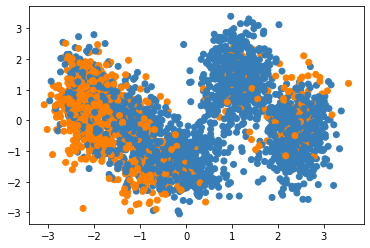

In [17]:
X = train_df.drop(label_col, axis=1).values
y = train_df[label_col].values

colors = np.array(['#377eb8', '#ff7f00'])

pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors[y.astype(int)])

In [18]:
i = 0

for p, s in zip(params, scores):
    print('Model:{}    Score:{:.3f}   Embeddings:{}    Heads:{}    Hidden:{}'.format(
        i,
        s,
        p['module__ninp'],
        p['module__nhead'],
        p['module__nhid']
    ))
    i += 1

Model:0    Score:0.984   Embeddings:128    Heads:4    Hidden:2
Model:1    Score:1.000   Embeddings:128    Heads:8    Hidden:2
Model:2    Score:0.946   Embeddings:128    Heads:1    Hidden:2
Model:3    Score:0.990   Embeddings:128    Heads:2    Hidden:2
Model:4    Score:0.999   Embeddings:128    Heads:128    Hidden:2
Model:5    Score:1.000   Embeddings:128    Heads:32    Hidden:2
Model:6    Score:0.994   Embeddings:128    Heads:16    Hidden:2
Model:7    Score:0.995   Embeddings:128    Heads:64    Hidden:2


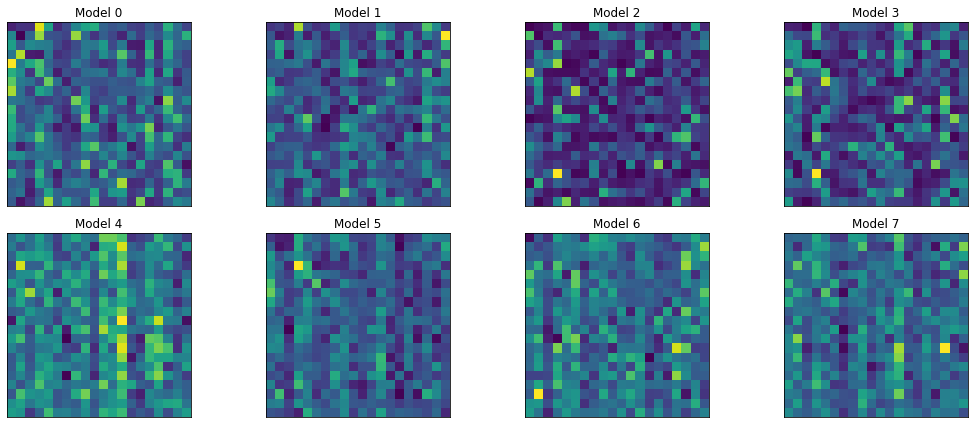

In [19]:
test_range = [i for i in range(len(params))]

total_tests = len(test_range)
cols = 4
rows = math.ceil(total_tests / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for row in range(rows):
    for col in range(cols):
        ax = axes[row, col]
        
        test_index = row * cols + col
        
        if test_index < len(test_range):
            n_model = test_range[test_index]  
            
            attn_mat = attn[n_model].mean(axis=0).reshape(n_features, n_features)
            attn_var = attn[n_model].var(axis=0).reshape(n_features, n_features)
            
            ax.imshow(attn_mat)
            ax.set_title('Model {}'.format(n_model))
            
            #for i in range(2):
            #    for j in range(2):
            #        text = ax.text(j, i, '{:.2f}-{:.2f}'.format(attn_mat[i, j], attn_var[i, j]), ha="center", va="center", color="w")
            
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

fig.tight_layout()
fig.savefig('Attention clustering.png')
plt.show()

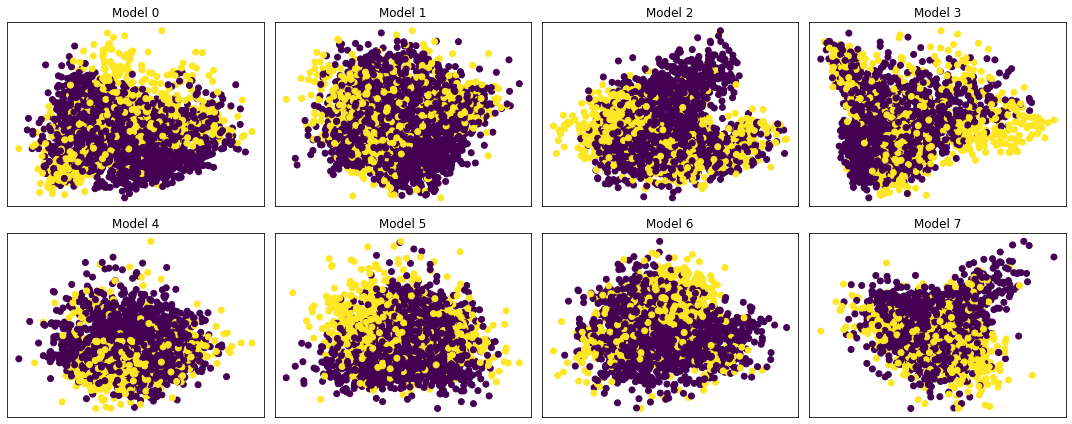

In [20]:
test_range = [i for i in range(len(params))]

total_tests = len(test_range)
cols = 4
rows = math.ceil(total_tests / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for row in range(rows):
    for col in range(cols):
        ax = axes[row, col]
        
        test_index = row * cols + col
        
        if test_index < len(test_range):
            n_model = test_range[test_index]
            
            pca = decomposition.PCA(n_components=2)
            attn_pca = pca.fit_transform(attn[n_model])
            
            ax.scatter(attn_pca[:, 0], attn_pca[:, 1], c=train_df[label_col])
            ax.set_title('Model {}'.format(n_model))
            
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

fig.tight_layout()
fig.savefig('Attention clustering.png')
plt.show()

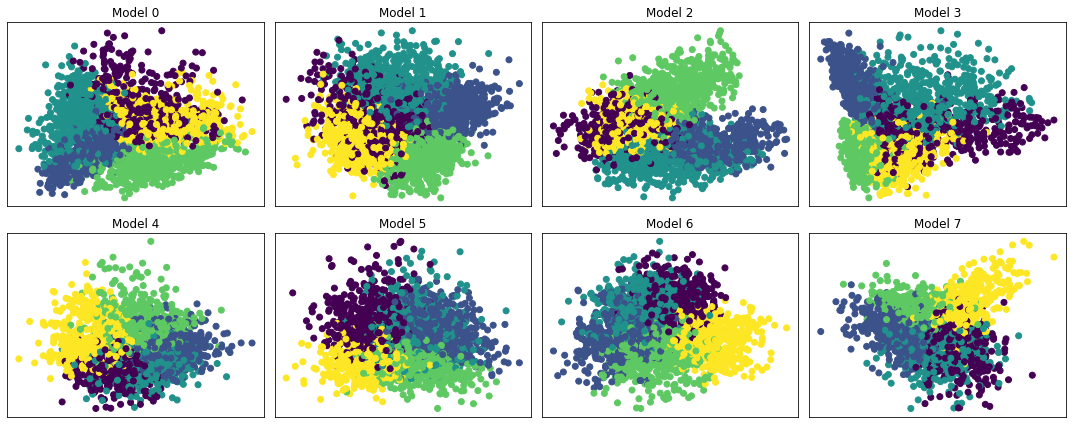

In [21]:
test_range = [i for i in range(len(params))]

total_tests = len(test_range)
cols = 4
rows = math.ceil(total_tests / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for row in range(rows):
    for col in range(cols):
        ax = axes[row, col]
        
        test_index = row * cols + col
        
        if test_index < len(test_range):
            n_model = test_range[test_index]
            
            pca = decomposition.PCA(n_components=2)
            attn_pca = pca.fit_transform(attn[n_model])
            
            ax.scatter(attn_pca[:, 0], attn_pca[:, 1], c=train_df['model'])
            ax.set_title('Model {}'.format(n_model))
            
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

fig.tight_layout()
fig.savefig('Attention clustering.png')
plt.show()